In [ ]:
Initial Setup

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
np.bool = np.bool_

#current notebook name
notebook_name = __session__.replace('.ipynb','')[__session__.rfind('/')+1:] 

# HDFS base paths
hdfs_lakehouse_base_path = 'hdfs://localhost:9000/lakehouse/'
hdfs_warehouse_base_path = 'hdfs://localhost:9000/warehouse'

import os
dependencies = ["org.apache.spark:spark-avro_2.12:3.5.0",
                "io.delta:delta-iceberg_2.12:3.0.0"]
os.environ['PYSPARK_SUBMIT_ARGS']= f"--packages {','.join(dependencies)} pyspark-shell"
os.environ['PYARROW_IGNORE_TIMEZONE'] = 'true'

from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName(notebook_name)
    .config("spark.log.level","ERROR")
    .config("spark.sql.warehouse.dir",hdfs_warehouse_base_path)
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .enableHiveSupport()
    .getOrCreate()
)

Bronze Layer (Ingestion)


In [8]:


# Load dataset into the Bronze layer (ensure the file path is correct and enclosed properly)
olympics_brz = spark.read.csv("/home/osbdet/notebooks/Group_Assignment/Olympics Athletes Dataset (1990-2016) - athlete_events-1.csv", header=True, inferSchema=True)

# Save raw data to HDFS (Bronze layer)
olympics_brz.write.format("parquet").mode("overwrite").save(hdfs_warehouse_base_path)

# Display the loaded data to verify
olympics_brz.show(5)




+---+--------------------+---+---+------+------+--------------+---+-----------+----+------+---------+-------------+--------------------+-----+
| ID|                Name|Sex|Age|Height|Weight|          Team|NOC|      Games|Year|Season|     City|        Sport|               Event|Medal|
+---+--------------------+---+---+------+------+--------------+---+-----------+----+------+---------+-------------+--------------------+-----+
|  1|           A Dijiang|  M| 24|   180|    80|         China|CHN|1992 Summer|1992|Summer|Barcelona|   Basketball|Basketball Men's ...|   NA|
|  2|            A Lamusi|  M| 23|   170|    60|         China|CHN|2012 Summer|2012|Summer|   London|         Judo|Judo Men's Extra-...|   NA|
|  3| Gunnar Nielsen Aaby|  M| 24|    NA|    NA|       Denmark|DEN|1920 Summer|1920|Summer|Antwerpen|     Football|Football Men's Fo...|   NA|
|  4|Edgar Lindenau Aabye|  M| 34|    NA|    NA|Denmark/Sweden|DEN|1900 Summer|1900|Summer|    Paris|   Tug-Of-War|Tug-Of-War Men's ...| Gold|

In [ ]:
Converting Bronze Layer to Pandas

In [9]:
olympics_brz.printSchema()

olympics_brz.limit(10).toPandas()


root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Height: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- NOC: string (nullable = true)
 |-- Games: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Medal: string (nullable = true)



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
5,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NA
6,5,Christine Jacoba Aaftink,F,25,185,82,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NA
7,5,Christine Jacoba Aaftink,F,25,185,82,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",NA
8,5,Christine Jacoba Aaftink,F,27,185,82,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,NA
9,5,Christine Jacoba Aaftink,F,27,185,82,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",NA


In [ ]:
Final Silver Layer Transformation in Format that has minimum processor load.

In [11]:
from pyspark.sql.functions import col, when, upper, trim, round

# Create the schema (database) if it does not exist
spark.sql("CREATE DATABASE IF NOT EXISTS olympics")

# Process and save the Silver layer in Delta format
(
    spark.read
    .option("header", "true")
    .csv("/home/osbdet/notebooks/Group_Assignment/Olympics Athletes Dataset (1990-2016) - athlete_events-1.csv")
    # Convert ID column to bigint
    .withColumn("ID", col("ID").cast("bigint"))
    # Replace "NA" with "No Medal" in the Medal column
    .withColumn("Medal", when(col("Medal") == "NA", "No Medal").otherwise(col("Medal")))
    # Calculate BMI and round to 2 decimal places
    .withColumn("BMI", round(col("Weight") / (col("Height") / 100) ** 2, 2))
    # Add Medal_Won as a binary column
    .withColumn("Medal_Won", when(col("Medal").isin("Gold", "Silver", "Bronze"), 1).otherwise(0))
    # Trim all text columns
    .select([trim(col(c)).alias(c) if str(col(c).dataType) == "StringType" else col(c) for c in spark.read
             .option("header", "true")
             .csv("/home/osbdet/notebooks/Group_Assignment/Olympics Athletes Dataset (1990-2016) - athlete_events-1.csv")
             .columns])
    # Standardize NOC column to uppercase
    .withColumn("NOC", upper(col("NOC")))
    # Drop the Team column
    .drop("Team")
    # Remove duplicates
    .dropDuplicates()
    # Save as Delta format in the specified schema
    .write
    .format("delta")
    .mode("overwrite")
    .save("/home/osbdet/notebooks/Group_Assignment/silver_olympics_data")
)

# Read directly from path
olympics_silver = spark.read.format("delta").load("/home/osbdet/notebooks/Group_Assignment/silver_olympics_data")
olympics_silver.show(10)

DataFrame[]

+----+--------------------+---+---+------+------+---+-----------+----+------+--------------+----------+--------------------+--------+
|  ID|                Name|Sex|Age|Height|Weight|NOC|      Games|Year|Season|          City|     Sport|               Event|   Medal|
+----+--------------------+---+---+------+------+---+-----------+----+------+--------------+----------+--------------------+--------+
| 150|Margaret Ives Abb...|  F| 23|    NA|    NA|USA|1900 Summer|1900|Summer|         Paris|      Golf|Golf Women's Indi...|    Gold|
| 171|  Mahmoud Abdel Aziz|  M| 25|   174|    70|EGY|2000 Summer|2000|Summer|        Sydney|Volleyball|Volleyball Men's ...|No Medal|
| 211|  Sameh Abdel Rahman|  M| 16|    NA|    NA|UAR|1960 Summer|1960|Summer|          Roma|   Fencing|Fencing Men's Foi...|No Medal|
| 229|Mohamed Ali Abdelaal|  M| 26|   175|    81|EGY|2016 Summer|2016|Summer|Rio de Janeiro|      Judo|Judo Men's Half-M...|No Medal|
| 520|Sidney Solomon Ab...|  M| 21|    NA|    NA|GBR|1906 Summ

In [ ]:
Silver to Gold Transformation

In [14]:
from pyspark.sql.functions import col, count, avg, sum, when, round, trim, upper

# Step 1: Load the raw CSV file and save as a Delta table (Silver Layer)
silver_df = (
    spark.read
    .option("header", "true")
    .csv("/home/osbdet/notebooks/Group_Assignment/Olympics Athletes Dataset (1990-2016) - athlete_events-1.csv")
    # Convert ID column to bigint
    .withColumn("ID", col("ID").cast("bigint"))
    # Replace "NA" with "No Medal" in the Medal column
    .withColumn("Medal", when(col("Medal") == "NA", "No Medal").otherwise(col("Medal")))
    # Calculate BMI and round to 2 decimal places
    .withColumn("BMI", round(col("Weight") / (col("Height") / 100) ** 2, 2))
    # Add Medal_Won as a binary column
    .withColumn("Medal_Won", when(col("Medal").isin("Gold", "Silver", "Bronze"), 1).otherwise(0))
    # Standardize NOC column to uppercase
    .withColumn("NOC", upper(trim(col("NOC"))))
    # Drop the Team column
    .drop("Team")
    # Remove duplicates
    .dropDuplicates()
)

# Save the Silver layer as a Delta table
silver_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("/home/osbdet/notebooks/Group_Assignment/silver_olympics_data")




In [32]:
from pyspark.sql.functions import col, when, lit, avg, count, rank, first, last, round, trim, upper
from pyspark.sql.window import Window

# Step 1: Add Continent Column
# Updated NOC-to-Continent Mapping
noc_to_continent = {
    # North America
    "USA": "North America", "CAN": "North America", "MEX": "North America",
    "CUB": "North America", "JAM": "North America", "DOM": "North America",
    "GUA": "North America", "HON": "North America", "PAN": "North America",
    "CRC": "North America", "BAR": "North America", "BAH": "North America",
    "TTO": "North America", "BER": "North America", "SKN": "North America",

    # South America
    "BRA": "South America", "ARG": "South America", "CHI": "South America",
    "COL": "South America", "VEN": "South America", "ECU": "South America",
    "URU": "South America", "PAR": "South America", "PER": "South America",
    "GUY": "South America", "SUR": "South America",

    # Europe
    "GBR": "Europe", "GER": "Europe", "FRA": "Europe", "ITA": "Europe",
    "ESP": "Europe", "NED": "Europe", "SWE": "Europe", "DEN": "Europe",
    "NOR": "Europe", "BEL": "Europe", "POL": "Europe", "HUN": "Europe",
    "CZE": "Europe", "SVK": "Europe", "AUT": "Europe", "RUS": "Europe",
    "FIN": "Europe", "POR": "Europe", "ROU": "Europe", "BUL": "Europe",
    "SUI": "Europe", "LTU": "Europe", "LAT": "Europe", "EST": "Europe",

    # Africa
    "KEN": "Africa", "RSA": "Africa", "ETH": "Africa", "NGR": "Africa",
    "UGA": "Africa", "GHA": "Africa", "ZIM": "Africa", "BOT": "Africa",
    "NAM": "Africa", "MAR": "Africa", "EGY": "Africa", "ALG": "Africa",
    "TUN": "Africa", "SEN": "Africa", "SLE": "Africa", "CIV": "Africa",

    # Asia
    "CHN": "Asia", "JPN": "Asia", "KOR": "Asia", "IND": "Asia",
    "THA": "Asia", "KAZ": "Asia", "UZB": "Asia", "IRN": "Asia",
    "TPE": "Asia", "MAS": "Asia", "VIE": "Asia", "INA": "Asia",
    "PHI": "Asia", "SYR": "Asia", "JOR": "Asia", "KSA": "Asia",
    "QAT": "Asia", "UAE": "Asia",

    # Oceania
    "AUS": "Oceania", "NZL": "Oceania", "FIJ": "Oceania", "PNG": "Oceania",
    "SAM": "Oceania", "TGA": "Oceania", "VAN": "Oceania", "TUV": "Oceania",

    # Other (Unknown or Historic Codes)
    "URS": "Europe", "EUN": "Europe", "FRG": "Europe", "GDR": "Europe",
    "YUG": "Europe", "ANZ": "Oceania", "IOA": "Unknown", "UNK": "Unknown",
}

# Assign "Unknown" to any remaining unmapped NOCs
unique_nocs = silver_df.select("NOC").distinct().rdd.flatMap(lambda x: x).collect()
unmapped_nocs = set(unique_nocs) - set(noc_to_continent.keys())
for noc in unmapped_nocs:
    noc_to_continent[noc] = "Unknown"

# Create a mapping DataFrame for NOC-to-Continent
continent_mapping = spark.createDataFrame(
    [(noc, continent) for noc, continent in noc_to_continent.items()],
    ["NOC", "Continent"]
)

# Join the mapping DataFrame with the Silver Layer
gold_df = silver_df.join(continent_mapping, on="NOC", how="left")

# Step 2: Add Age Buckets
gold_df = gold_df.withColumn(
    "AgeBucket",
    when(col("Age") < 20, "<20")
    .when((col("Age") >= 20) & (col("Age") <= 30), "20-30")
    .when((col("Age") > 30) & (col("Age") <= 40), "30-40")
    .otherwise(">40")
)

# Step 3: Add Athlete Longevity
window_athlete = Window.partitionBy("ID").orderBy("Year")
gold_df = gold_df.withColumn("FirstYear", first("Year").over(window_athlete)) \
                 .withColumn("LastYear", last("Year").over(window_athlete)) \
                 .withColumn("CareerSpan", col("LastYear") - col("FirstYear") + 1)

# Step 4: Add Medal Efficiency by NOC
gold_df = gold_df.groupBy("NOC").agg(
    count("ID").alias("TotalAthletes"),
    count(when(col("Medal") != "No Medal", 1)).alias("TotalMedals")
).withColumn(
    "MedalEfficiency", round(col("TotalMedals") / col("TotalAthletes"), 2)
).join(gold_df, on="NOC", how="left")

# Step 5: Add Dominant Sport by NOC
window_noc_sport = Window.partitionBy("NOC").orderBy(col("TotalMedals").desc())
gold_df = gold_df.groupBy("NOC", "Sport").agg(count("Medal").alias("TotalMedals")) \
                 .withColumn("Rank", rank().over(window_noc_sport)) \
                 .filter(col("Rank") == 1) \
                 .select("NOC", col("Sport").alias("DominantSport")) \
                 .join(gold_df, on="NOC", how="left")

# Step 6: Add BMI Category
gold_df = gold_df.withColumn(
    "BMICategory",
    when(col("BMI") < 18.5, "Underweight")
    .when((col("BMI") >= 18.5) & (col("BMI") < 25), "Normal")
    .when((col("BMI") >= 25) & (col("BMI") < 30), "Overweight")
    .otherwise("Obese")
)

# Step 7: Add Gender Diversity Index
gold_df = gold_df.groupBy("NOC").agg(
    count(when(col("Sex") == "M", 1)).alias("MaleCount"),
    count(when(col("Sex") == "F", 1)).alias("FemaleCount")
).withColumn(
    "GenderDiversityIndex",
    round(col("FemaleCount") / (col("MaleCount") + col("FemaleCount")), 2)
).join(gold_df, on="NOC", how="left")

# Save Gold Layer as Delta Table
gold_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("/home/osbdet/notebooks/Group_Assignment/gold_olympics_data")


In [ ]:
Analytics and Visualizations:

In [ ]:
1. Age Tend over Time - Top 3 Sports

Text(0, 0.5, 'Average Age')

Text(0.5, 0, 'Year')

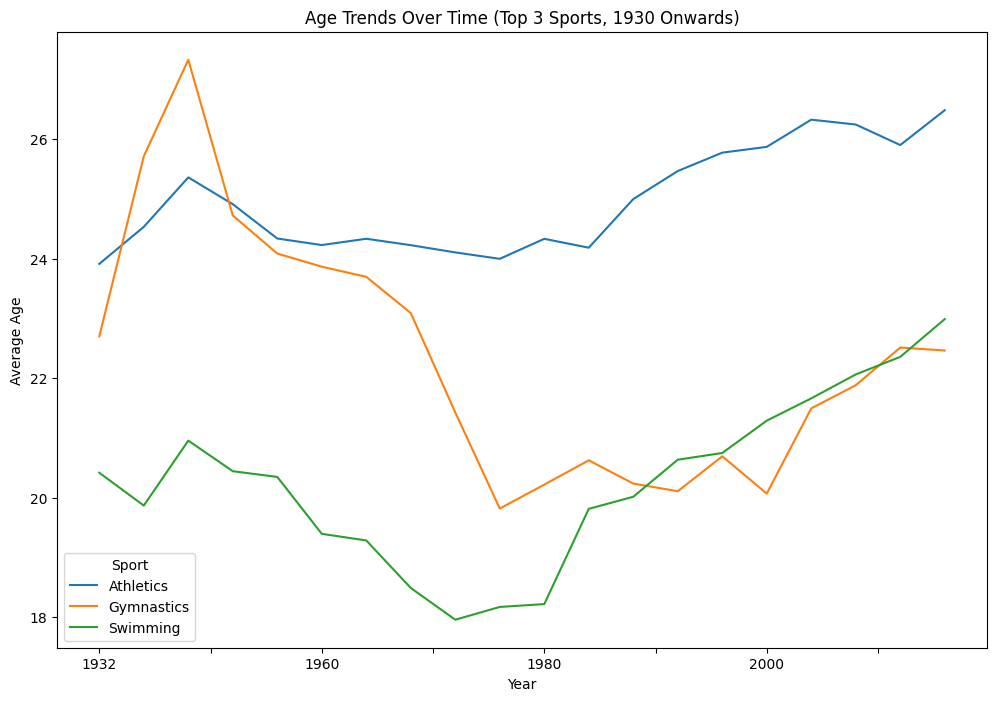

In [33]:
from pyspark.sql.functions import col, avg

# Step 1: Filter for Top 3 Sports by Participation
top_3_sports = (
    gold_df.groupBy("Sport")
    .count()
    .orderBy(col("count").desc())
    .limit(3)
    .select("Sport")
    .rdd.flatMap(lambda x: x)
    .collect()
)

# Step 2: Calculate Age Trends for Top 3 Sports (1930 Onwards)
age_trends_top_3 = (
    gold_df.filter((col("Sport").isin(top_3_sports)) & (col("Year") >= 1930))
    .groupBy("Year", "Sport")
    .agg(avg("Age").alias("AvgAge"))
    .orderBy("Year", "Sport")
)

# Step 3: Convert to Pandas for Visualization
age_trends_pd = age_trends_top_3.toPandas()

# Step 4: Pivot the Data for Visualization
pivoted_age_data = age_trends_pd.pivot_table(
    index="Year", columns="Sport", values="AvgAge", aggfunc="mean", fill_value=0
)

# Step 5: Plot the Graph
ax = pivoted_age_data.plot(kind="line", figsize=(12, 8), title="Age Trends Over Time (Top 3 Sports, 1930 Onwards)")
ax.set_ylabel("Average Age")
ax.set_xlabel("Year")


In [ ]:
2. Participation Tend over Time - Top 3 Sports

Text(0, 0.5, 'Number of Participants')

Text(0.5, 0, 'Year')

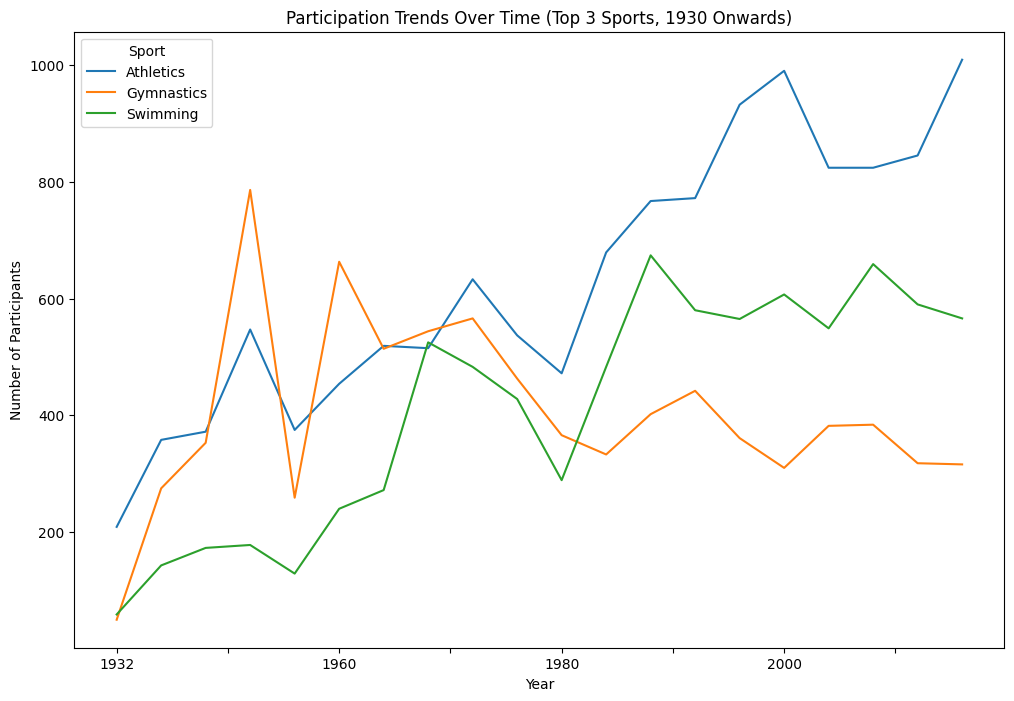

In [34]:

participation_trends_top_3 = (
    gold_df.filter((col("Sport").isin(top_3_sports)) & (col("Year") >= 1930))
    .groupBy("Year", "Sport")
    .count()
    .orderBy("Year", "Sport")
)

# Step 3: Convert to Pandas for Visualization
participation_trends_pd = participation_trends_top_3.toPandas()

# Step 4: Pivot the Data for Visualization
pivoted_data = participation_trends_pd.pivot_table(
    index="Year", columns="Sport", values="count", aggfunc="sum", fill_value=0
)

# Step 5: Plot the Graph with Updated Y-Axis and Restricted Years
ax = pivoted_data.plot(kind="line", figsize=(12, 8), title="Participation Trends Over Time (Top 3 Sports, 1930 Onwards)")
ax.set_ylabel("Number of Participants")
ax.set_xlabel("Year")


In [ ]:
3. Top Performing Countries by Medals

<Axes: title={'center': 'Top Performing Countries by Medals'}, xlabel='NOC'>

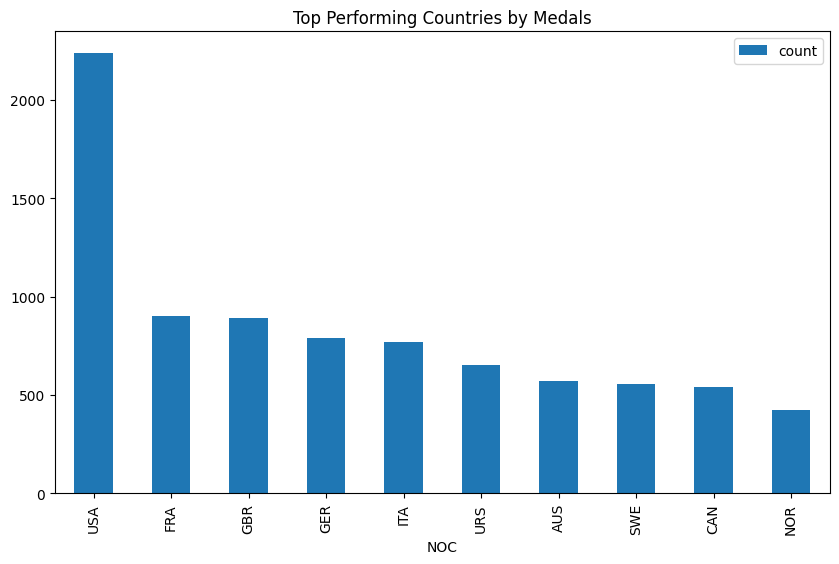

In [35]:
from pyspark.sql.functions import desc

# Calculation
top_countries = (
    gold_df.filter(col("Medal") != "No Medal")
    .groupBy("NOC")
    .count()
    .orderBy(desc("count"))
    .limit(10)
)

# Visualization
top_countries_pd = top_countries.toPandas()
top_countries_pd.plot(
    x="NOC", y="count", kind="bar", figsize=(10, 6), title="Top Performing Countries by Medals"
)


In [ ]:
4. Most Popular Sports

<Axes: title={'center': 'Most Popular Sports'}, xlabel='Sport'>

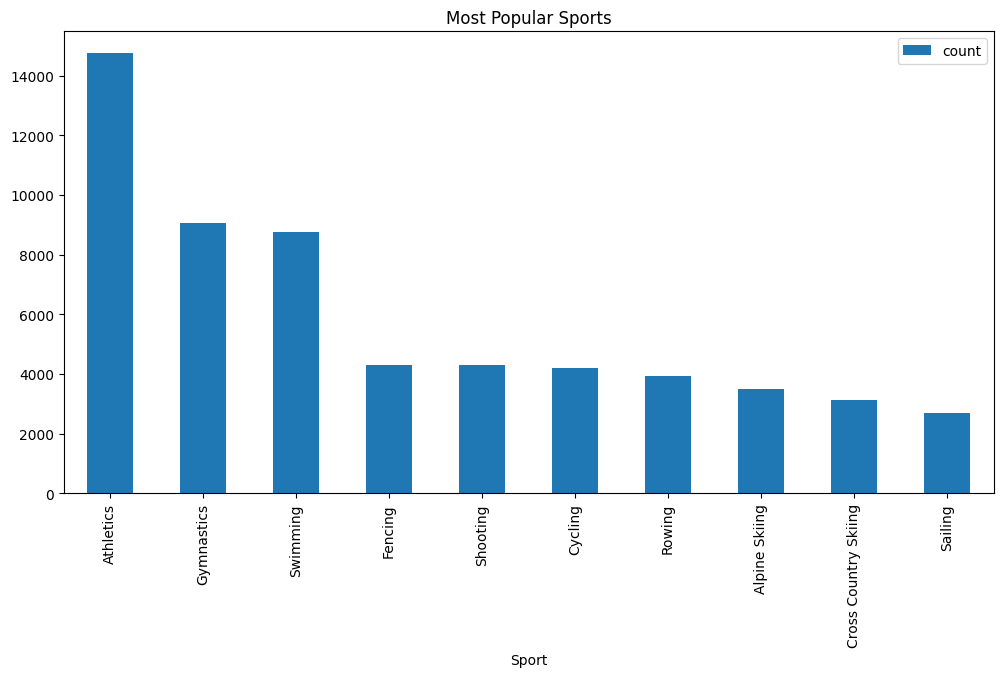

In [36]:
# Calculation
popular_sports = gold_df.groupBy("Sport").count().orderBy(desc("count")).limit(10)

# Visualization
popular_sports_pd = popular_sports.toPandas()
popular_sports_pd.plot(
    x="Sport", y="count", kind="bar", figsize=(12, 6), title="Most Popular Sports"
)


In [ ]:
5. Participation by Continent

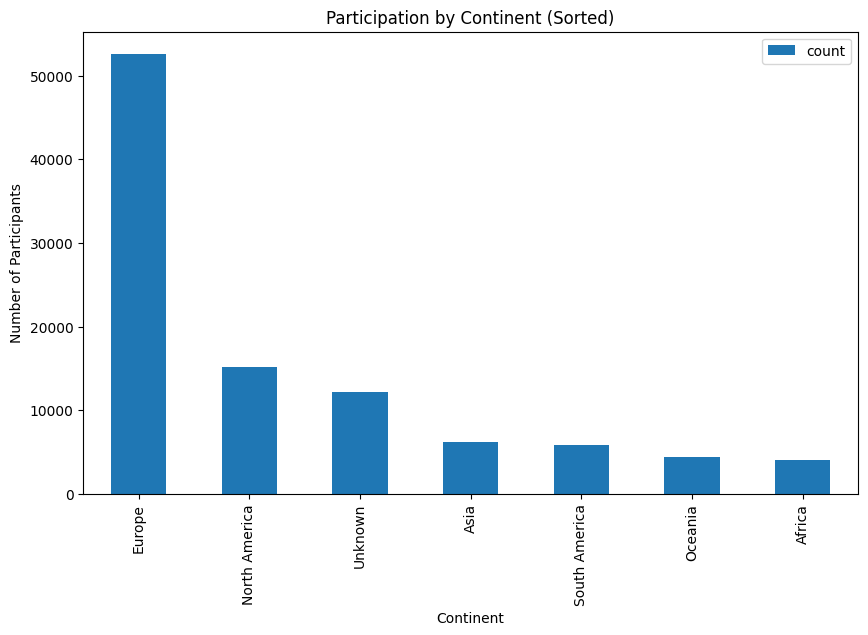

In [39]:
participation_by_continent = gold_df.groupBy("Continent").count().orderBy(col("count").desc())

to_pandas_and_plot(
    participation_by_continent, x="Continent", y="count", kind="bar",
    title="Participation by Continent", xlabel="Continent", ylabel="Number of Participants"
)


In [ ]:
6. Athlete Distribution by Age Bucket

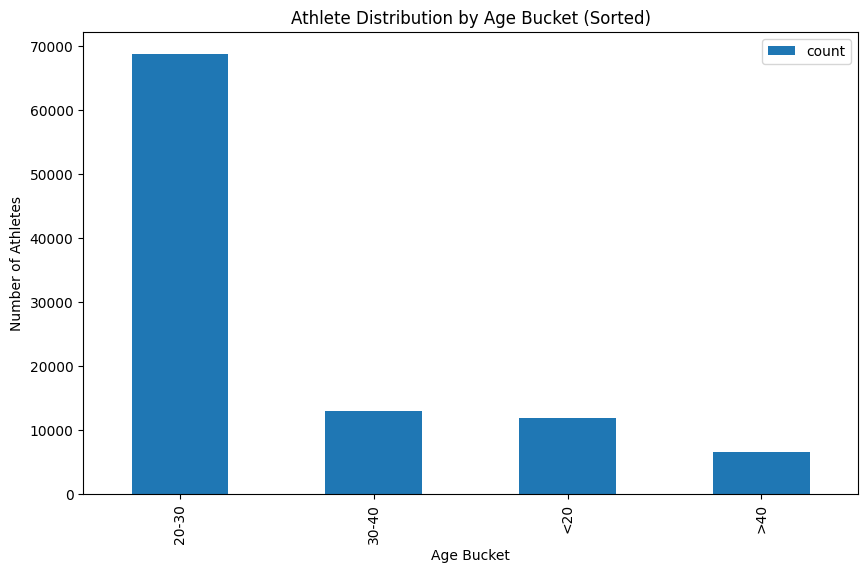

In [42]:
age_bucket_distribution = gold_df.groupBy("AgeBucket").count().orderBy(col("count").desc())

to_pandas_and_plot(
    age_bucket_distribution, x="AgeBucket", y="count", kind="bar",
    title="Athlete Distribution by Age Bucket (Sorted)", xlabel="Age Bucket", ylabel="Number of Athletes"
)


In [ ]:
7. BMI Categories by Continent

Text(0, 0.5, 'Number of Athletes')

Text(0.5, 0, 'Continent')

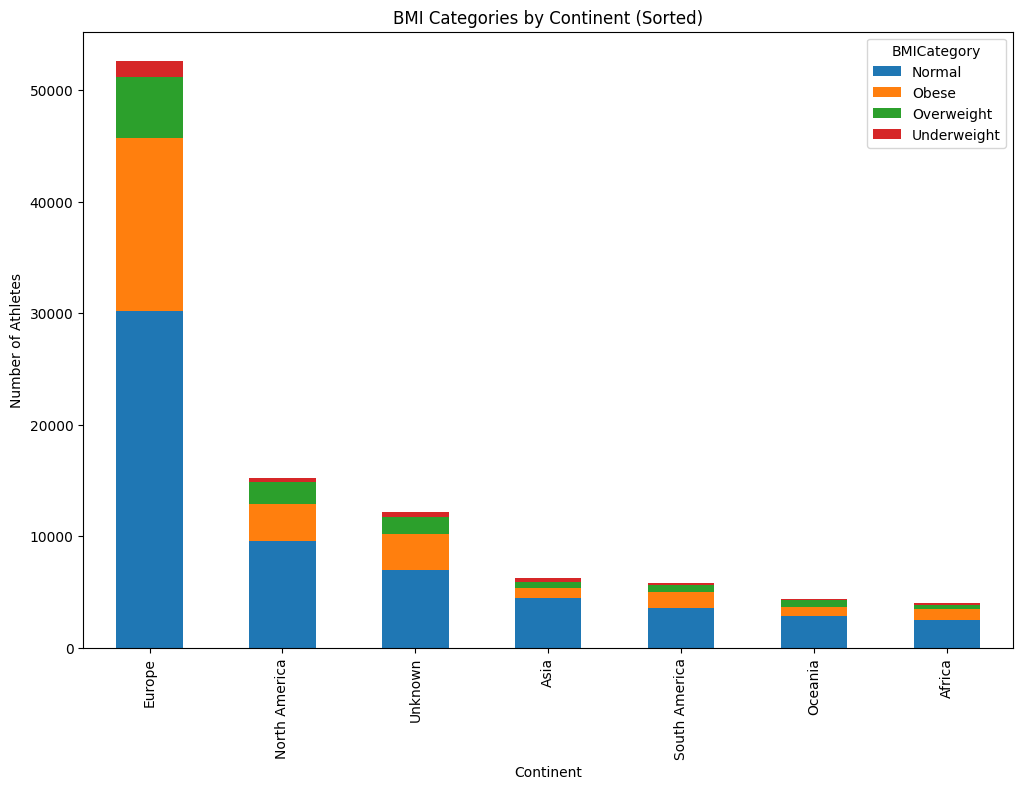

In [46]:
bmi_by_continent = gold_df.groupBy("Continent", "BMICategory").count().orderBy(col("count").desc())

bmi_pivot = bmi_by_continent.toPandas().pivot(index="Continent", columns="BMICategory", values="count").fillna(0)
ax = bmi_pivot.sort_values(by=bmi_pivot.columns.tolist(), ascending=False).plot(
    kind="bar", stacked=True, figsize=(12, 8), title="BMI Categories by Continent (Sorted)"
)
ax.set_ylabel("Number of Athletes")
ax.set_xlabel("Continent")
plt.show()


In [ ]:
8. Gender Diversity by Continent

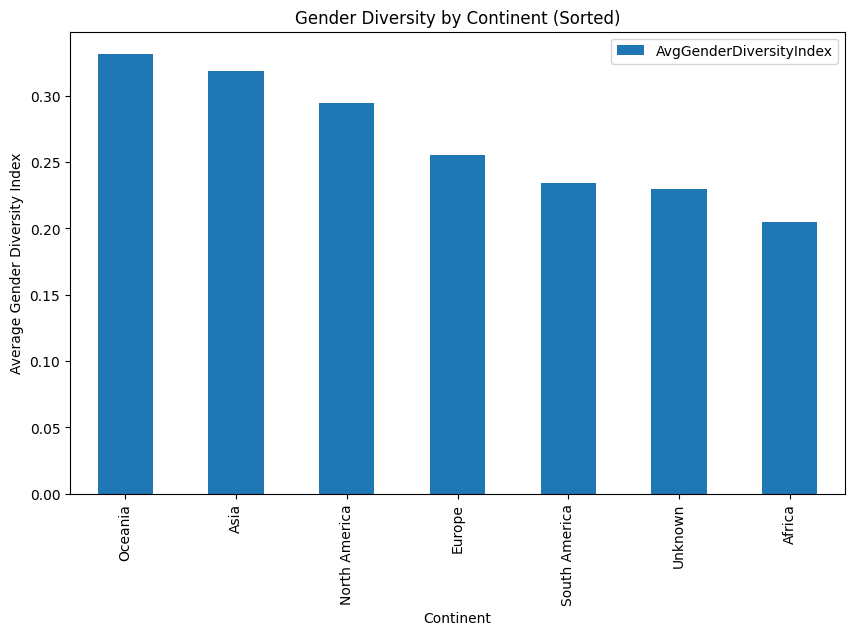

In [47]:
gender_diversity = gold_df.groupBy("Continent").agg(avg("GenderDiversityIndex").alias("AvgGenderDiversityIndex")).orderBy(col("AvgGenderDiversityIndex").desc())

to_pandas_and_plot(
    gender_diversity, x="Continent", y="AvgGenderDiversityIndex", kind="bar",
    title="Gender Diversity by Continent (Sorted)", xlabel="Continent", ylabel="Average Gender Diversity Index"
)


In [ ]:
9. Population-Normalized Medal Performance

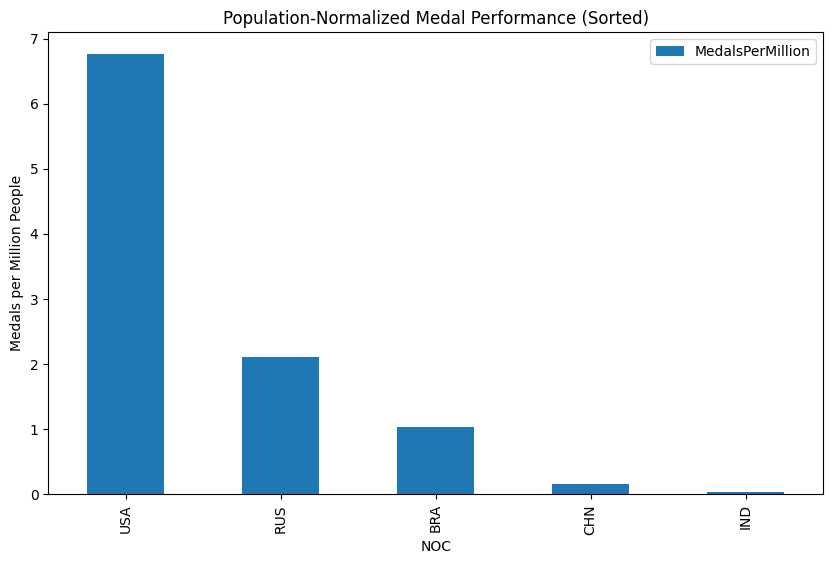

In [48]:
population_normalized = gold_df.groupBy("NOC").agg(
    count(when(col("Medal") != "No Medal", 1)).alias("TotalMedals")
).join(population_df, on="NOC", how="inner").withColumn(
    "MedalsPerMillion", round(col("TotalMedals") / (col("Population") / 1e6), 2)
).orderBy(col("MedalsPerMillion").desc())

to_pandas_and_plot(
    population_normalized, x="NOC", y="MedalsPerMillion", kind="bar",
    title="Population-Normalized Medal Performance (Sorted)", xlabel="NOC", ylabel="Medals per Million People"
)
